In [1]:
# initiation date: 2023-03-27

import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import constrNMPy
from pytensor import tensor as pt 
import os 

print(f"Running on PyMC v{pm.__version__}")

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# os.getcwd() 
os.chdir('/Users/abel/Desktop/Junior/CogMod/Assignments/H3') # change the working directory to the folder where the data is stored

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.1.2


In [2]:
az.style.use("arviz-white")

## 题目二 

Alice参加一个选择题测验，每次测验包含99道单选题，每道题有4个选项，4个选项中有且仅有一个选项正确。进行测验时，每答对一道题计1分，答错一道题计0分，每次测验总分99分。测验总共进行10次，去除分数最高的2次与最低的2次后，以中间的6次作为最终成绩。假设每次测验中，Alice答对每个题目的概率相同，且在不同题目上和不同测验上的成绩都相互独立。已知Alice最终的成绩分别为22，25，30，38，40，48分。设Alice对单个题目的正确率为$\theta$。\
（可以参考Lee & Wagenmakers (2013)书Section 5.5中Cha Sa-soon的例子）

### Q1
用MLE的方法估计$\theta$，请在答案中
1. 写出$\theta$的log likelihood function；
2. 画出log likelihood随$\theta$变化的函数图像；
3. 报告$\theta$的MLE估计值。

根据题意，假设每道题目的正确率相同且为 $\theta$，则每道题目答对的概率为 $\theta$，答错的概率为 $1-\theta$。设 $X_i$ 表示 Alice 在第 $i$ 次测验中答对的题目数，则 $X_i$ 服从二项分布 $B(99,\theta)$。则第 $i$ 次测验中的总分 $Y_i$ 可以表示为 $Y_i = X_i$。

根据题目中的要求，去除最高的2次与最低的2次后，剩下的6次测验的得分为 $Y_{(3)}, Y_{(4)}, \ldots, Y_{(8)}$，其中 $Y_{(k)}$ 表示第 $k$ 小的得分。则 Alice 的最终得分为 $\sum_{i=3}^8 Y_{(i)}$。

根据最大似然估计的方法，我们可以求出 $\theta$ 的最大似然估计值 $\hat{\theta}$，使得观测数据的联合概率密度函数 $f(\boldsymbol{y};\theta)$ 在 $\theta=\hat{\theta}$ 处取得最大值。其中 $\boldsymbol{y}=(y_1,\ldots,y_6)$ 是观测到的 Alice 的最终得分数据。

在这里，$\mu$表示$Y$的均值，$\sigma^2$表示$Y$的方差。由于去除了最高分和最低分，因此$Y$的取值范围为$99\times 2\le Y \le 99\times 6$。

接下来，我们可以将似然函数表示为$Y$的密度函数。因为我们已经知道了$Y$的分布，所以可以将似然函数表示为：

In [38]:
UL = 48; LL = 22; Utime = 2; Ltime = 2; theta = 0.34;
binom = stats.binom(99,theta) # Binomial distribution
lowrang = np.arange(0, LL+1)
upprang = np.arange(UL, 100)
p_lower = np.log(np.sum(binom.pmf(lowrang))) * Ltime
p_upper = np.log(np.sum(binom.pmf(upprang))) * Utime

print(p_lower + p_upper)



-22.199017627321517


Object `TensorVariable` not found.


In [41]:

def censor_MLE(theta, LL, Ltime, UL, Utime, questnum = 99):
    '''Censor the parameter vector.
    Input:
        theta: the parameter vector
        LB: the lower bound of the observed data
        Ltime: the time when the lower bound is reached
        UB: the upper bound of the observed data
        Utime: the time when the upper bound is reached
    Output:
        lower + upper: the log-likelihood of the lower and upper bounds
    '''
    binom = stats.binom(questnum,theta) # Binomial distribution
    lowrang = np.arange(0, LL+1)
    upprang = np.arange(UL, 100)
    p_lower = np.log(np.sum(binom.pmf(lowrang))) * Ltime
    p_upper = np.log(np.sum(binom.pmf(upprang))) * Utime

    return p_lower+p_upper # log-likelihood of the lower and upper bounds

def nll_test(theta, allscores , questionnum = 99):
    '''Negative log-likelihood function for the test data.
    Input:
        theta: the parameter vector
        allscores: the test data in a list
    Output:
        nll: the negative log-likelihood
    '''
    nll = 0; 
    UL = 48; LL = 22; Utime = 2; Ltime = 2;
    testtimes = len(allscores);
    for i in range(testtimes):
        nll +=  -(np.log(theta)*allscores[i] + (questionnum-allscores[i])*np.log((1-theta)));
    nll += -censor_MLE(theta, LL, Ltime, UL, Utime)

    return nll

In [42]:
obscore = [22, 25, 30, 38, 40, 48]
questionnum = 99

# Use multiple random starting points to increase the probability of finding the global minimum.
import time
start = time.time()
args = (obscore)
LB = [0.25];
UB = [1];


# give it a try using intial parameters
from scipy.optimize import minimize
model_params = [0.5]
model_params_est = minimize(nll_test, model_params, args=args, method='Nelder-Mead', tol=1e-6).x
model_params_est

# use multiple ranom starting point to find the global minimum
N_random=100
optimal=[]
for i in range(N_random):
    theta = np.random.uniform(0.25, 1, 1); # random starting point
    LB = [0.25]; UB = [1];
    xopt = constrNMPy.constrNM(nll_test, theta, LB=LB, UB=UB, args = [args], full_output=True)
    optimal.append(xopt['xopt'])
y = list(map(lambda params: nll_test(theta, args), optimal)) # optional: use full output from constrNM
opt = optimal[y.index(min(y))]
print('Estimated parameters using MLE: theta = ' + str(opt))

Estimated parameters using MLE: theta = [0.34671565]


### Q2
用Bayesian inference的方法估计$\theta$，设$\theta$的先验分布为$\alpha=2,\beta=5$的$Beta$分布，即$\theta\sim \text{Beta}(2, 5)$，请在答案中
1. 利用MCMC对$\theta$进行采样，画出$\theta$的后验分布；
2. 报告$\theta$的Bayesian inference估计值。

这个过程中，可以认为99道题目答对正确的数目X服从二项分布$Binomial(99,\theta)$，共进行10次这样的过程得到 $X_i (i = 1,2...10)$。

而$\theta$是一个随机变量，其分布为$Beta(2,5)$。


即，我们现在已知：
$$ \theta \sim Beta(2,5) $$
$$ X_i \sim Binomial(99,\theta) $$


In [15]:
observed_data = [22, 25, 30, 38, 40, 48]
questionnum = 99
theta = 0.34
LB = 22; UB = 28;
Ltime =2; Utime =2;
binom = pm.Binomial.dist(n=99, p=theta) # Binomial distribution
lowrang = np.arange(0, LB+1)
lower = pm.logp(binom, lowrang).sum() * Ltime


In [14]:
?pm.logp

Signature: pm.logp(rv: pytensor.tensor.var.TensorVariable, value) -> pytensor.tensor.var.TensorVariable
Docstring: Return the log-probability graph of a Random Variable
File:      ~/miniconda3/envs/pymc_env/lib/python3.9/site-packages/pymc/logprob/joint_logprob.py
Type:      function

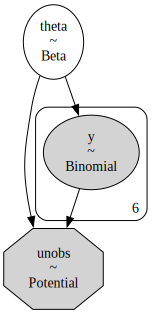

In [19]:
observed_data = [22, 25, 30, 38, 40, 48]
questionnum = 99

def censor(theta, LB, Ltime, UB, Utime):
    '''Censor the parameter vector.
    Input:
        theta: the parameter vector
        LB: the lower bound of the observed data
        Ltime: the time when the lower bound is reached
        UB: the upper bound of the observed data
        Utime: the time when the upper bound is reached
    Output:
        lower + upper: the log-likelihood of the lower and upper bounds
    '''
    binom = pm.Binomial.dist(n=99, p=theta) # Binomial distribution
    lowrang = pt.arange(0, pt.cast(LB + 1, 'int32'))
    upprang = pt.arange(pt.cast(UB, 'int32'), 100)
    p_lower = pm.math.sum(pm.math.exp(pm.logp(binom,lowrang))) * Ltime
    p_upper = pm.math.sum(pm.math.exp(pm.logp(binom,upprang))) * Utime

    return pm.math.log(p_lower+p_upper) # log-likelihood of the lower and upper bounds

with pm.Model() as alice_model:
    # prior
    theta = pm.Beta('theta', alpha=1, beta=1)
    
    # observed likelihood
    y = pm.Binomial('y', n=99, p=theta, observed=observed_data)
    # censoring
    [LB, UB] = [pt.min(y), pt.max(y)]
    # [LB, UB] = [22, 48]
    unobs = pm.Potential('unobs', censor(theta, LB, 2, UB, 2))
    
   
pm.model_to_graphviz(alice_model) # model graph

In [20]:
# prior check
with alice_model:
    prior_alice = pm.sample_prior_predictive() # sample from the prior distribution
    
display(prior_alice)

    

/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_4099/3031439078.py:3: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_alice = pm.sample_prior_predictive() # sample from the prior distribution
Sampling: [theta, y]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

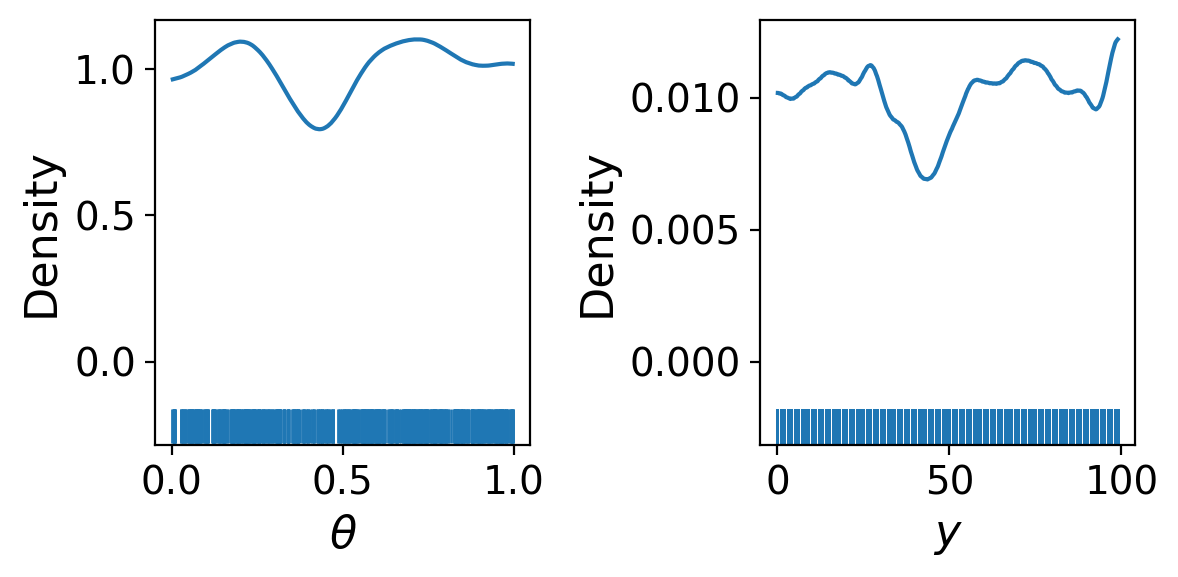

In [21]:
_, axes = plt.subplots(1, 2, figsize=(6, 3))
fs = 16

# plot prior
az.plot_dist(prior_alice.prior["theta"].values.flatten(), ax=axes[0], kind="kde", rug=True)
axes[0].set_xlabel(r"$\theta$", fontsize=fs)
axes[0].set_ylabel("Density", fontsize=fs)

# plot prior predictive
az.plot_dist(prior_alice.prior_predictive["y"].values.flatten(), ax=axes[1], kind="kde", rug=True)
axes[1].set_xlabel(r"$y$", fontsize=fs)
axes[1].set_ylabel("Density", fontsize=fs)
plt.tight_layout();

In [22]:
with alice_model:
    trace_alice = pm.sample()
    
display(trace_alice)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [23]:
az.summary(trace_alice)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.337,0.026,0.292,0.387,0.001,0.001,1417.0,2467.0,1.0


/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_60504/3585400070.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


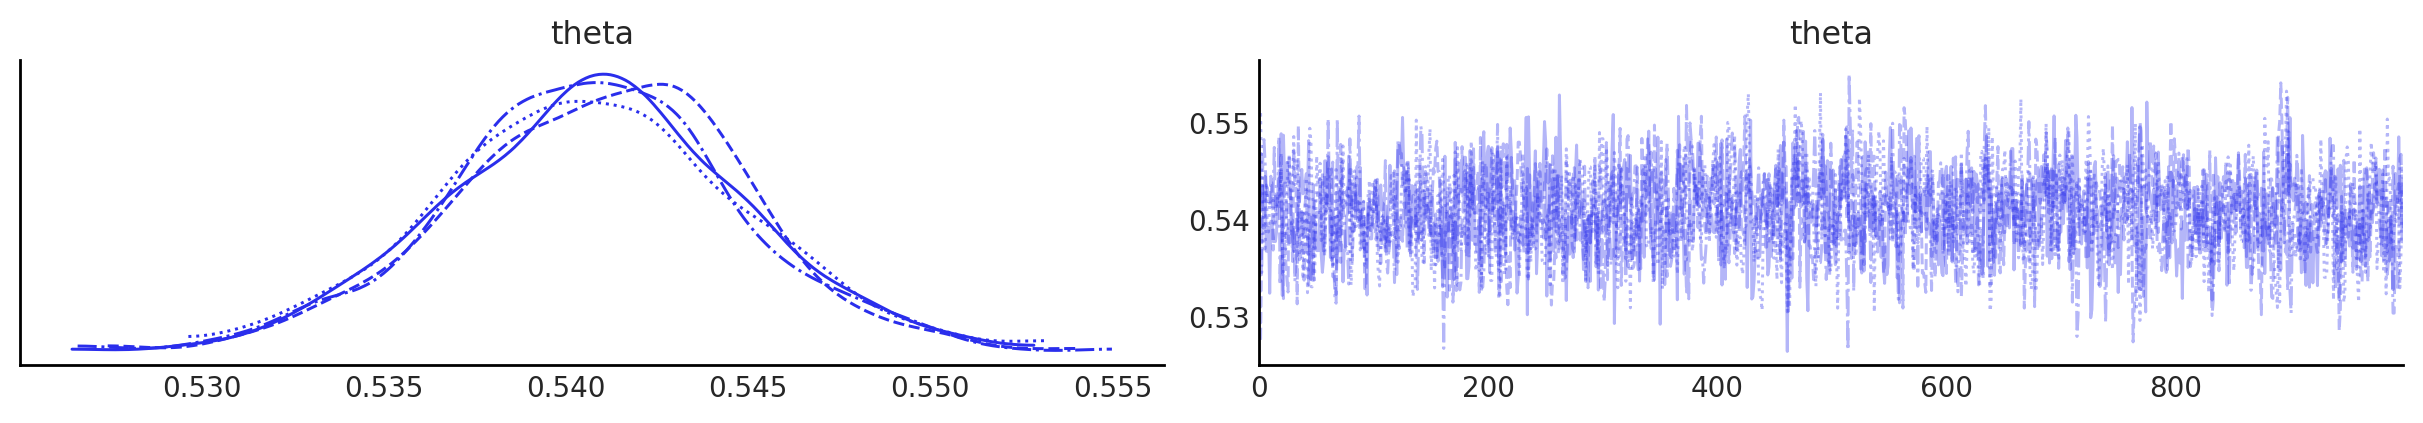

In [62]:
# Trace plot
az.plot_trace(trace_alice)
plt.tight_layout()

In [63]:
# posterior check
with alice_model:
    posterior_alice = pm.sample_posterior_predictive(trace_alice)

display(posterior_alice)

Inference data with groups:
	> posterior_predictive
	> observed_data

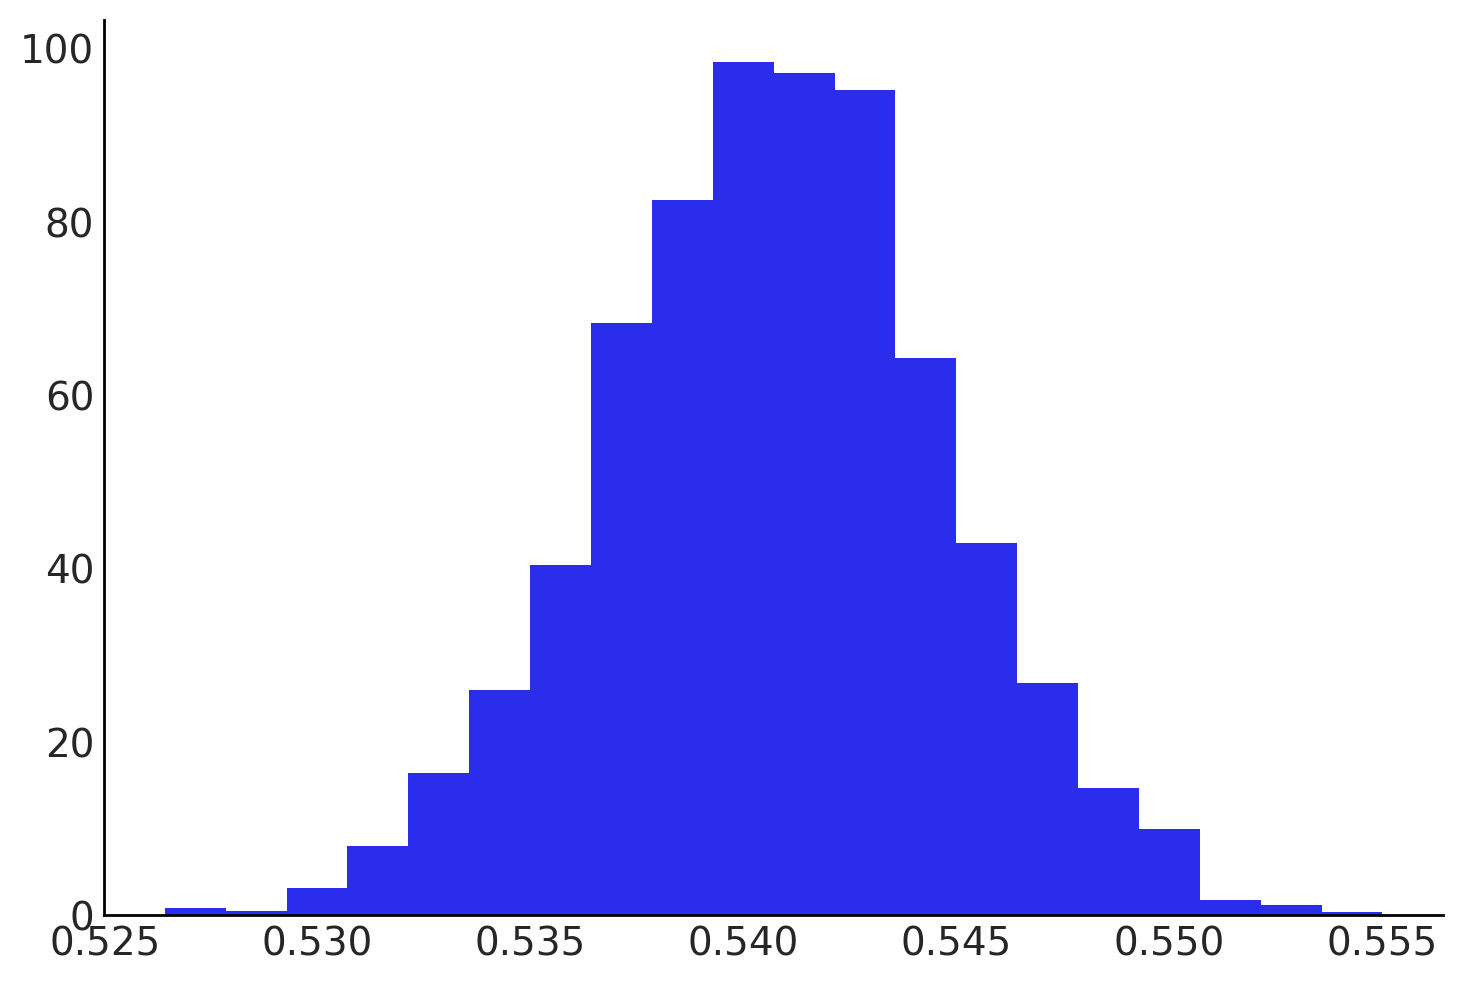

In [64]:
theta_posterior = trace_alice.posterior.theta.values.flatten()

plt.hist(theta_posterior, bins=20, density=True);

### Q3 
为了判断Alice是不是真的掌握了题目中的知识，我们将答对题目的概率$\theta$与几率水平($H_0: \theta=0.25$)进行比较。
1. 请使用 Savage-Dickey density ratio test (Section 7.6)，从$\theta$的后验分布中抽取500个sample，并作kernel平滑，计算假设$H_0: \theta=0.25$与$H_1: \theta\sim \text{Be}(2, 5)$的Bayes factor（重复50次）, 并描述相应结果。


Text(0, 0.5, 'Posterior Density')

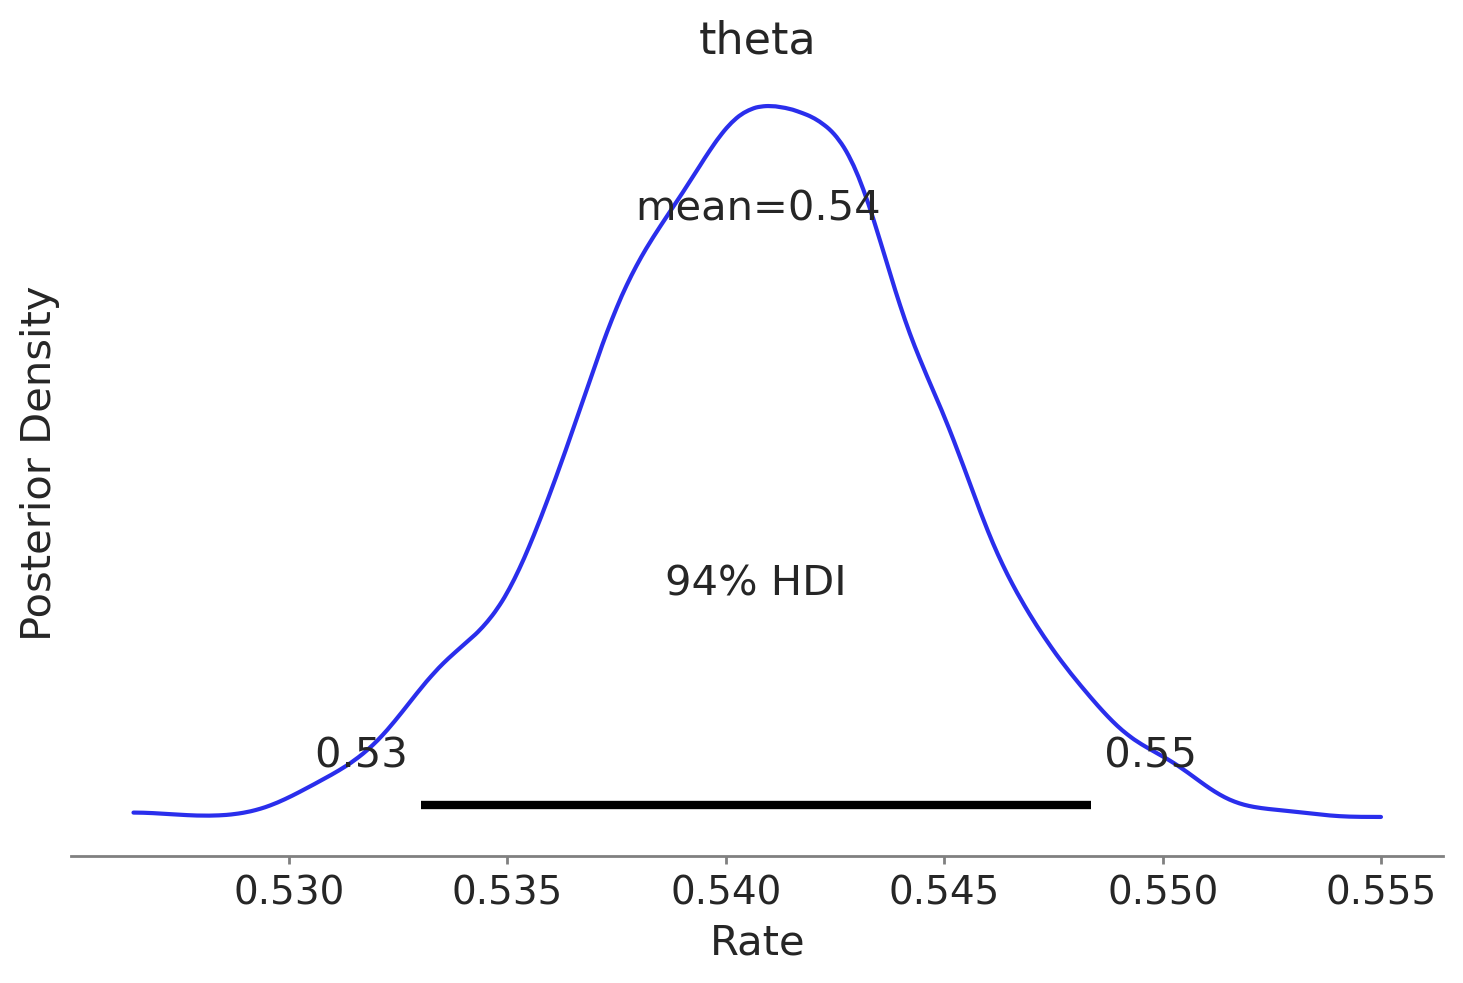

In [65]:
theta_post = trace_alice.posterior.theta.values.flatten()

# plot the density of the posterior distribution
a = az.plot_posterior(trace_alice, kind="kde");
a.set_xlabel("Rate")
a.set_ylabel("Posterior Density")

In [24]:
theta_post = trace_alice.posterior.theta.values.flatten()
min(theta_post), max(theta_post)

(0.2652179027497411, 0.4226678113623404)

In [67]:
theta_prior = prior_alice.prior.theta.values.flatten()
min(theta_prior), max(theta_prior)

(0.0012832005815307552, 0.9974977274834645)

The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.


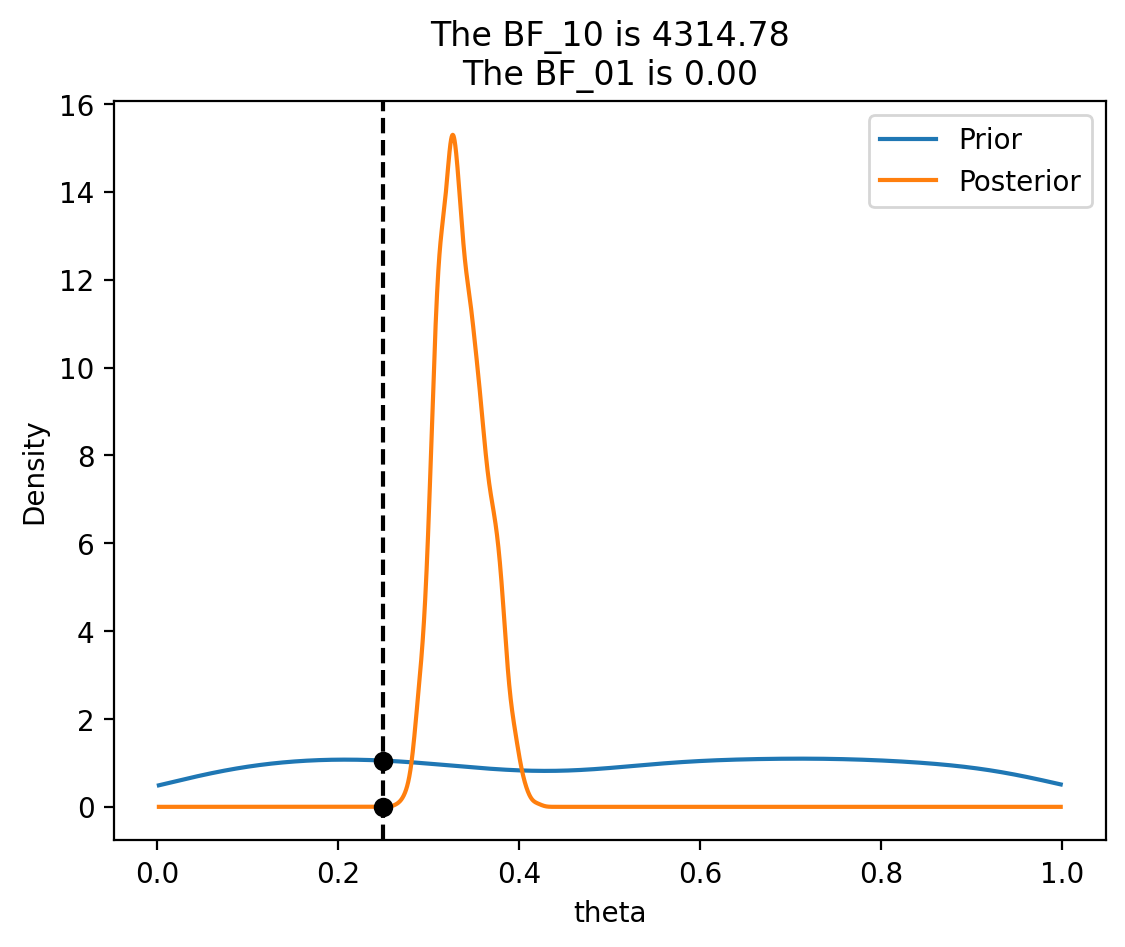

In [26]:
trace_alice.extend(prior_alice)

az.plot_bf(trace_alice, var_name="theta", ref_val=0.25);

In [22]:
# Calculate the Savage-Dickey density ratio
n_repeats = 50
BF_list = []

from scipy.stats import beta
from scipy.stats import gaussian_kde

theta0 = 0.25; 

for i in range(n_repeats):
    # sample from the posterior
    theta_sample = np.random.choice(theta_post, size=500, replace=True)
    # calculate the density ratio
    H0_pos = beta.pdf(theta_sample, a=1, b=1)  # prior
    H0_pos = gaussian_kde(H0_pos).evaluate(theta0) # posterior
    H1_pos = beta.pdf(theta_sample, 2, 5) # prior
    
    

    # calculate the Bayes factor
    bayes_factor = alternative_posterior / null_posterior
    
    # BF = np.mean(beta.pdf(theta_sample, 1, 1)/beta.pdf(theta_sample, 2, 5))
    



# Print the Bayes factors
print('Bayes factors: ', np.array(bf_list))

NameError: name 'posterior_samples' is not defined

2. 我们同样可以直接从先验分布中抽取样本，计算Bayes factor。根据定义，有$$BF_{10}=\frac{P(D|H_1)}{P(D|H_0)}=\frac{\int{P(D|\theta, H_1)P(\theta|H_1)}d{\theta}}{P(D|H_0)}$$请根据题目中的先验分布，抽取参数样本（500个）计算likelihood，求出Bayes factor（重复50次），与Savage-Dickey test的结果进行比较，并画出相应结果。

Bayes factors:  [1.12172303 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303
 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303
 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303
 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303
 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303
 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303
 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303
 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303 1.12172303
 1.12172303 1.12172303]


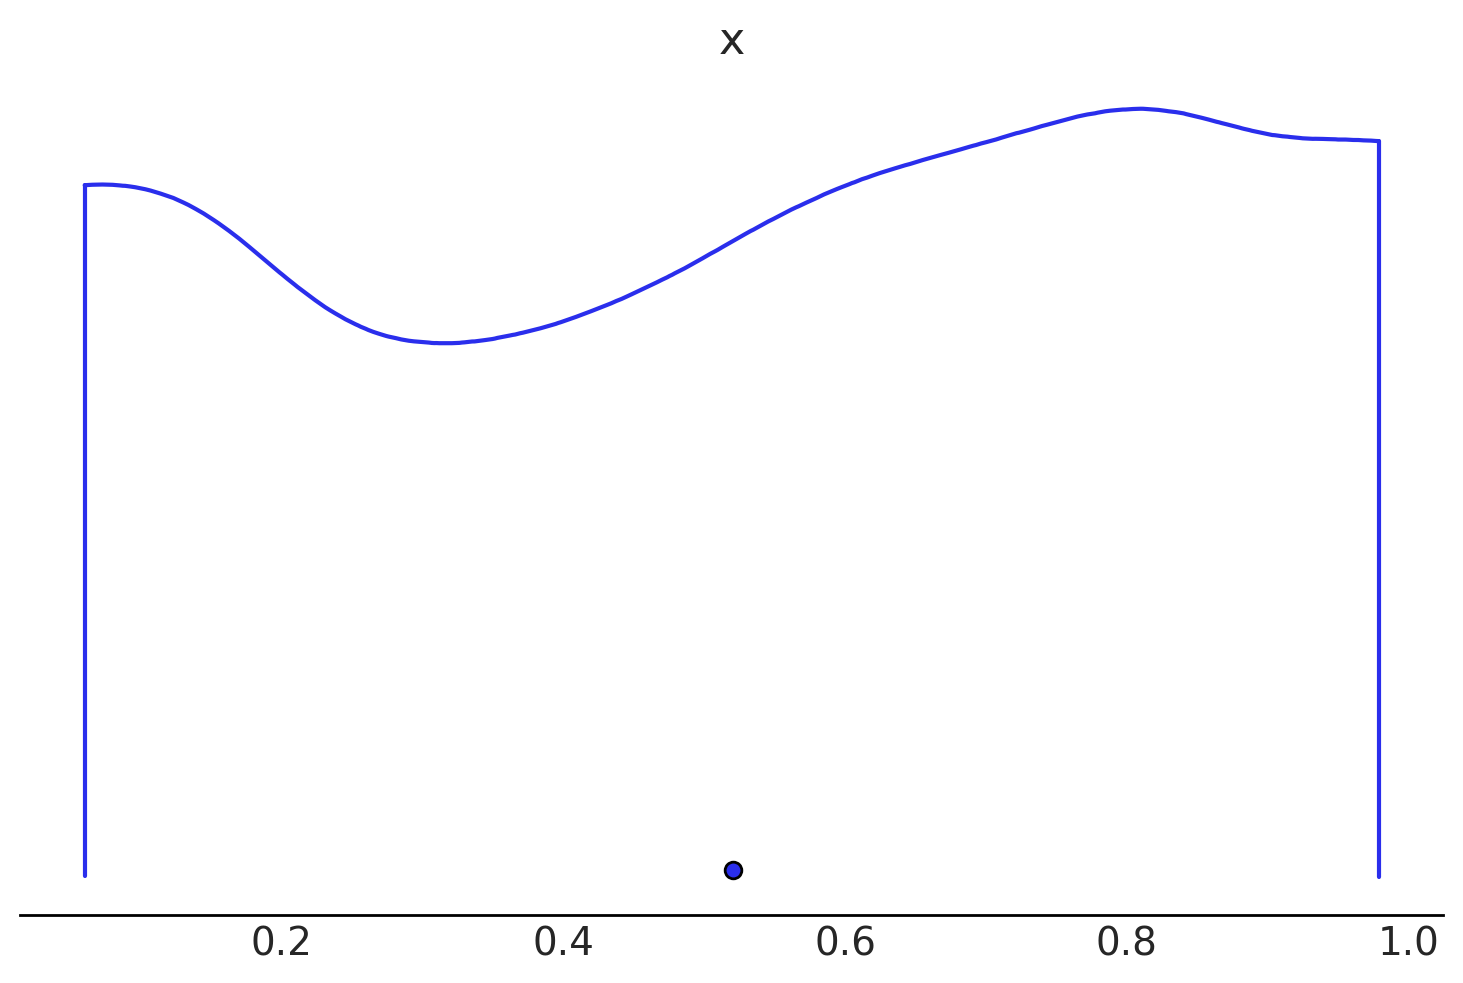

In [68]:
# Calculate the Bayes factor from the prior
n_repeats = 50; theta0 = 0.25
BF_list = []

from scipy.stats import beta
from scipy.stats import gaussian_kde
# plot the prior
a = az.plot_density(theta_prior);

for i in range(n_repeats):
    theta_sample = np.random.choice(theta_prior, size=500, replace=True)
    density_at_theta0 = gaussian_kde(theta_sample).evaluate(theta0)
    BF_list.append(density_ratio)
    
# Print the Bayes factors
print('Bayes factors: ', np.array(BF_list))

In [51]:
print(stats.kde.gaussian_kde(theta_prior).evaluate(theta0))
print(stats.gaussian_kde(theta_prior).evaluate(theta0))

[1.11326108]
[1.11326108]


/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_60504/521441550.py:1: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  print(stats.kde.gaussian_kde(theta_prior).evaluate(theta0))


在前面的例子中，我们比较了两个β-二项式模型，但有时我们想做的是比较一个空假设H_0（或空模型）和一个备选假设H_1。例如，为了回答这枚硬币是否有偏见的问题，我们可以将数值 
 (代表没有偏见)与一个模型的结果进行比较，我们让 
 变化。对于这种比较，空模型被嵌套在备选模型中，这意味着空模型是我们正在建立的模型的一个特定值。在这种情况下，计算贝叶斯系数是非常容易的，它不需要任何特殊的方法，因为数学计算起来很方便，所以我们只需要比较在空值下的先验和后验（例如 
），在替代模型下。我们可以从下面的表达式中看出这一点：

In [21]:
y = np.repeat([1, 0], [50, 50])  # 50 "heads" and 50 "tails"
priors = ((1, 1), (30, 30))

with pm.Model() as model_conc:
    a = pm.Beta("a", 30, 30)
    yl = pm.Bernoulli("yl", a, observed=y)
    idata_conc = pm.sample(2000, random_seed=42)
    idata_conc.extend(pm.sample_prior_predictive(8000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [a, yl]
